# Time Series

Dataset: https://www.kaggle.com/rakannimer/air-passengers

Links:
- https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
data = pd.read_csv("..\_datasets\AirPassengers.csv")
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## set data as Time Series (ts)

In [3]:
ts = data.copy()
ts['Month'] = pd.to_datetime(ts['Month'])
ts = ts.set_index('Month')
ts = ts['#Passengers']
print(ts.index)
ts

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, Length: 144, dtype: int64

## Frequency of datasets

https://stackoverflow.com/questions/61844725/how-to-set-datetime-index-frequency-in-workdays-time-series-pandas

- M: Month End
- MS: Month beging


In [4]:
ts = ts.asfreq('MS')
ts.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

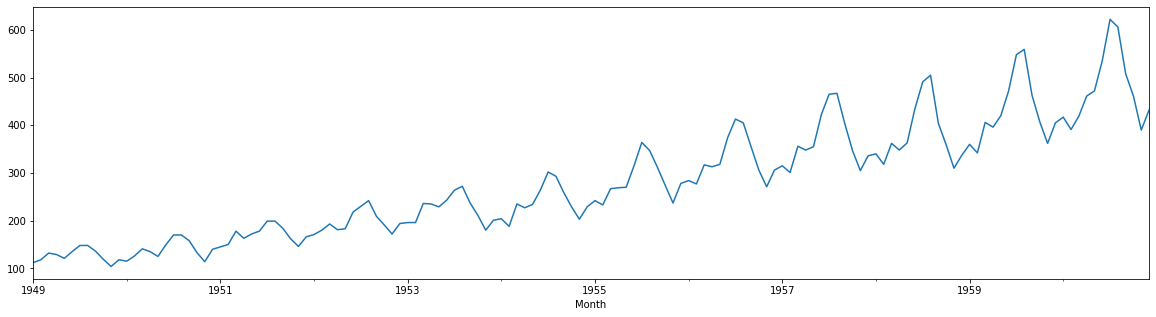

In [5]:
ts.plot(kind='line',figsize=(20,5));

Zoom in years 1950 to 1953

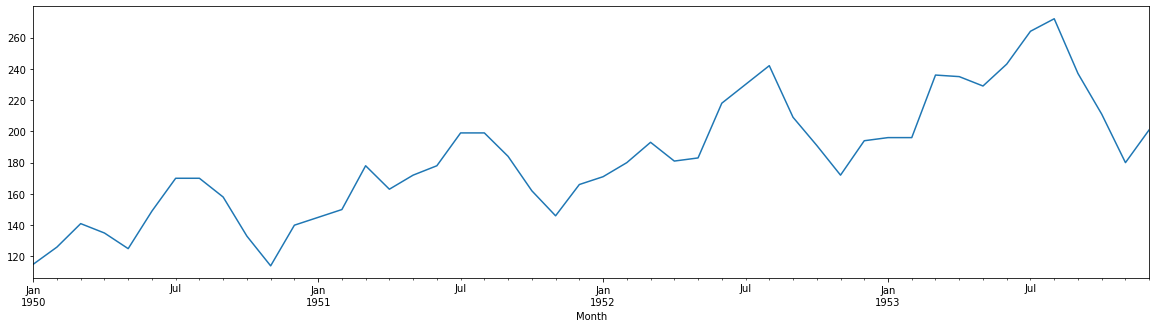

In [6]:
ts['1950':'1953'].plot(kind='line', figsize=(20,5));

## STATIONARITY

This is a very important concept in Time Series Analysis. In order to apply a time series model, it is important for the Time series to be stationary; in other words all its statistical properties (mean,variance) remain constant over time. This is done basically because if you take a certain behavior over time, it is important that this behavior is same in the future in order for us to forecast the series. There are a lot of statistical theories to explore stationary series than non-stationary series. (Thus we can bring the fight to our home ground!)

- constant mean
- constant variance
- an auto co-variance that does not depend on time


[Dickey-Fuller Test](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/): This is one of the statistical tests for checking stationarity. First we consider the null hypothesis: the time series is non- stationary. The result from the rest will contain the test statistic and critical value for different confidence levels. The idea is to have Test statistics less than critical value, in this case we can reject the null hypothesis and say that this Time series is indeed stationary (the force is strong with this one !!)

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
def test_stationarity(ts, window):
    #Determing rolling statistics
    rolmean = ts.rolling(window=window).mean()
    rolstd = ts.rolling(window=window).std()
    #Plot rolling statistics:
    plt.plot(ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    dftest = adfuller(ts, autolag='AIC')
    results = dict(zip(['Test Statistic','p-value','#Lags Used','Number of Observations Used'], dftest[:4]))
    results.update(dict((f"Critical value {k}",v) for k,v in dftest[4].items()))
    results.update({"Stationary": results['p-value']<0.05})
    return results

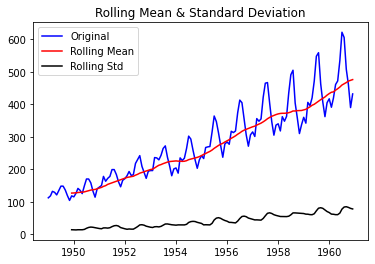

{'Test Statistic': 0.8153688792060482,
 'p-value': 0.991880243437641,
 '#Lags Used': 13,
 'Number of Observations Used': 130,
 'Critical value 1%': -3.4816817173418295,
 'Critical value 5%': -2.8840418343195267,
 'Critical value 10%': -2.578770059171598,
 'Stationary': False}

In [9]:
dftest = test_stationarity(ts, 12)
dftest

This is not stationary because :

- mean is increasing even though the std is small.
- Test stat is > critical value.
- Note: the signed values are compared and the absolute values.

### MAKING THE TIME SERIES STATIONARY

There are two major factors that make a time series non-stationary. They are:

- Trend: non-constant mean
- Seasonality: Variation at specific time-frames

The basic idea is to model the trend and seasonality in this series, so we can remove it and make the series stationary. Then we can go ahead and apply statistical forecasting to the stationary series. And finally we can convert the forecasted values into original by applying the trend and seasonality constrains back to those that we previously separated.

Let’s start by working on the trend piece.

**Trend**

The first step is to reduce the trend using transformation, as we can see here that there is a strong positive trend. These transformation can be log, sq-rt, cube root etc . Basically it penalizes larger values more than the smaller. In this case we will use the logarithmic transformation.

In [10]:
ts_log = np.log(ts)
ts_log

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Freq: MS, Name: #Passengers, Length: 144, dtype: float64

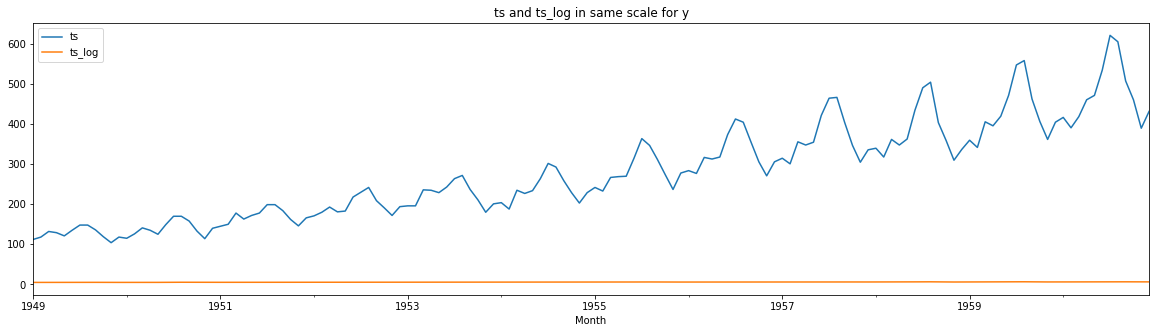

In [11]:
fig = plt.figure(figsize=(20,5))
ts.plot(kind="line", label='ts')
ts_log.plot(kind="line", label='ts_log')
plt.title("ts and ts_log in same scale for y")
plt.legend()
plt.show()

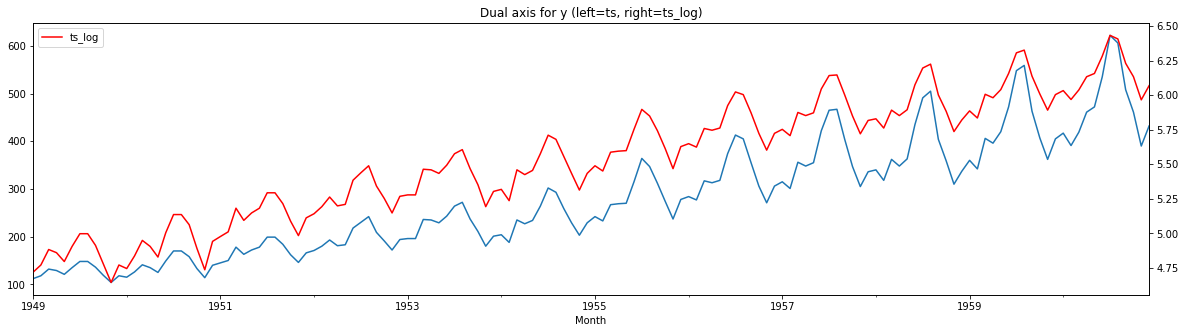

In [12]:
fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
ts.plot(kind="line", ax=ax)
ts_log.plot(kind="line", ax=ax2, color='red', label='ts_log')
plt.legend()
plt.title("Dual axis for y (left=ts, right=ts_log)")
plt.show()

There is some noise in realizing the forward trend here. There are some methods to model these trends and then remove them from the series. Some of the common ones are:

- Aggression: by taking the mean for a certain time period (year/month)
- Smoothing: using rolling/moving average. In smoothing we usually take the past few instances (rolling estimates) We will discuss two methods under smoothing
    - Moving average and Exponentially weighted moving average.
    - Moving average: First take x consecutive values and this depends on the frequency if it is 1 year we take 12 values. Lucky for us that Pandas has a function for rolling estimate.


In [13]:
moving_avg = ts_log.rolling(window=12).mean()
moving_avg

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
                ...   
1960-08-01    6.124517
1960-09-01    6.132246
1960-10-01    6.142628
1960-11-01    6.148837
1960-12-01    6.154215
Freq: MS, Name: #Passengers, Length: 144, dtype: float64

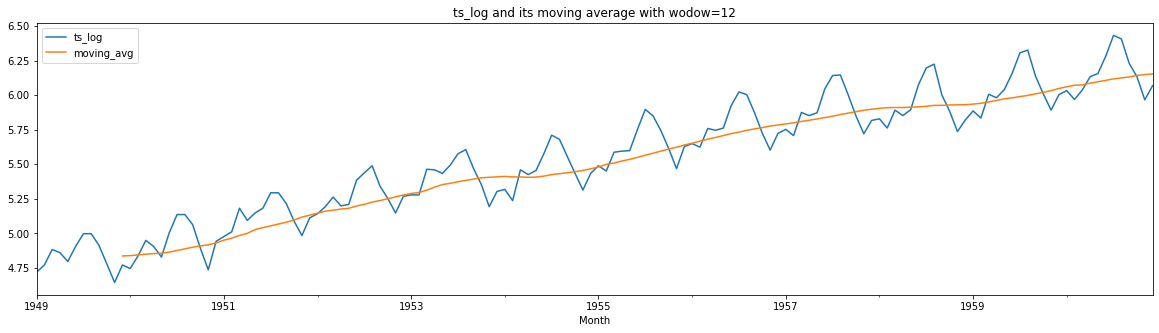

In [14]:
fig = plt.figure(figsize=(20,5))
ts_log.plot(kind="line", label='ts_log')
moving_avg.plot(kind="line", label='moving_avg')
plt.title("ts_log and its moving average with wodow=12")
plt.legend()
plt.show()

Normalization: ts - moving average

In [15]:
ts_log_diff = ts_log - moving_avg
ts_log_diff = ts_log_diff.dropna()
ts_log_diff

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
                ...   
1960-08-01    0.282363
1960-09-01    0.098235
1960-10-01   -0.009230
1960-11-01   -0.182690
1960-12-01   -0.085789
Freq: MS, Name: #Passengers, Length: 133, dtype: float64

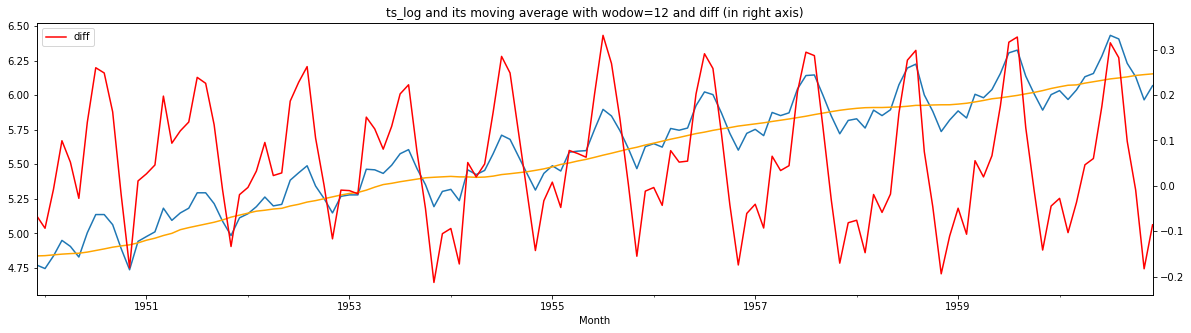

In [16]:
# fig = plt.figure(figsize=(20,5))
fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
ts_log.plot(kind="line", label='ts_log', ax=ax)
moving_avg.plot(kind="line", label='moving_avg', ax=ax, color='orange')
ts_log_diff.plot(kind="line", label='diff', ax=ax2, color='red')
plt.title("ts_log and its moving average with wodow=12 and diff (in right axis)")
plt.legend()
plt.show()

Test Log diff for stationarity

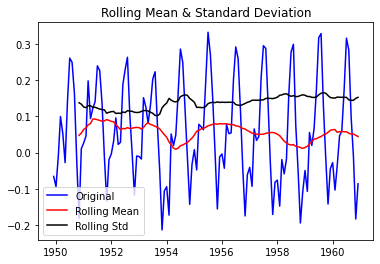

{'Test Statistic': -3.162907991300869,
 'p-value': 0.022234630001243157,
 '#Lags Used': 13,
 'Number of Observations Used': 119,
 'Critical value 1%': -3.4865346059036564,
 'Critical value 5%': -2.8861509858476264,
 'Critical value 10%': -2.579896092790057,
 'Stationary': True}

In [17]:
test_stationarity(ts_log_diff,12)

We notice two things:

- The rolling values are varying slightly but there is no specific trend.
- The **test statistics is smaller than the 5 % critical values**. That tells us that we are 95% confident that this series is stationary.

**exponentially weighted moving average**

In this example we can easily take a time period (12 months for a year), but there are situations where the time period range is more complex like stock price etc. So we use the exponentially weighted moving average (there are other weighted moving averages but for starters, lets use this). The previous values are assigned with a decay factor. Pandas again comes to the rescue with some awesome functions for it, like:

In [23]:
expw_avg = ts_log.ewm(halflife=12).mean()
expw_avg

Month
1949-01-01    4.718499
1949-02-01    4.745345
1949-03-01    4.793835
1949-04-01    4.811785
1949-05-01    4.808206
                ...   
1960-08-01    6.046445
1960-09-01    6.056778
1960-10-01    6.061079
1960-11-01    6.055750
1960-12-01    6.056461
Freq: MS, Name: #Passengers, Length: 144, dtype: float64

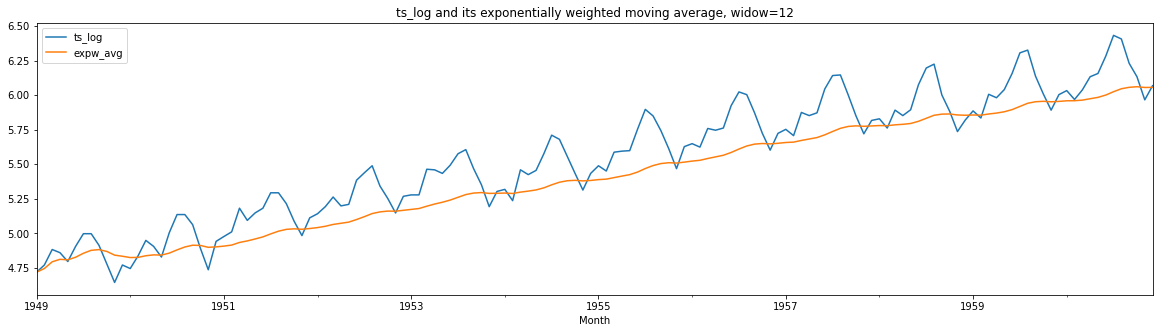

In [24]:
fig = plt.figure(figsize=(20,5))
ts_log.plot(kind="line", label='ts_log')
expw_avg.plot(kind="line", label='expw_avg')
plt.title("ts_log and its exponentially weighted moving average, widow=12")
plt.legend()
plt.show()

In [26]:
ts_log_diff_expw_avg = ts_log - expw_avg
ts_log_diff_expw_avg = ts_log_diff_expw_avg.dropna()
ts_log_diff_expw_avg

Month
1949-01-01    0.000000
1949-02-01    0.025339
1949-03-01    0.088967
1949-04-01    0.048028
1949-05-01   -0.012415
                ...   
1960-08-01    0.360435
1960-09-01    0.173704
1960-10-01    0.072319
1960-11-01   -0.089603
1960-12-01    0.011964
Freq: MS, Name: #Passengers, Length: 144, dtype: float64

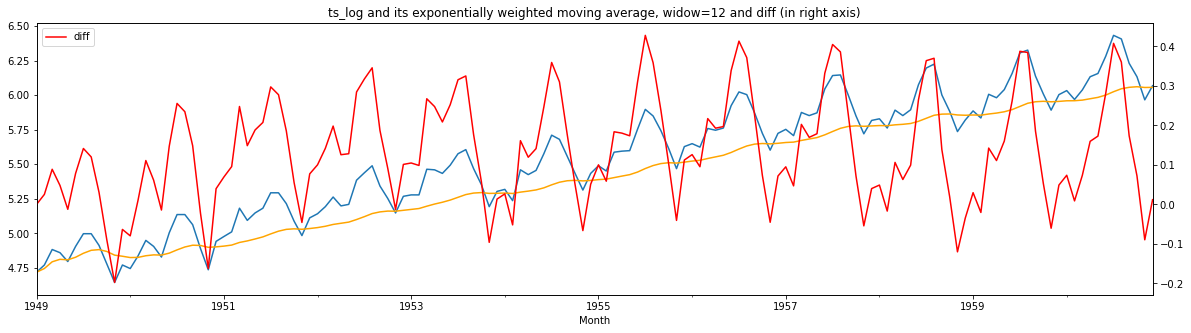

In [28]:
# fig = plt.figure(figsize=(20,5))
fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
ts_log.plot(kind="line", label='ts_log', ax=ax)
expw_avg.plot(kind="line", label='expw_avg', ax=ax, color='orange')
ts_log_diff_expw_avg.plot(kind="line", label='diff', ax=ax2, color='red')
plt.title("ts_log and its exponentially weighted moving average, widow=12 and diff (in right axis)")
plt.legend()
plt.show()

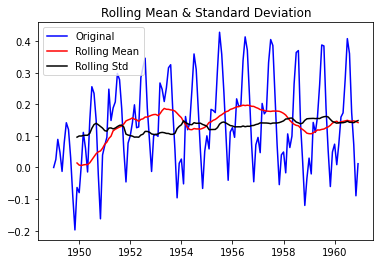

{'Test Statistic': -3.601262420161663,
 'p-value': 0.005736938801512151,
 '#Lags Used': 13,
 'Number of Observations Used': 130,
 'Critical value 1%': -3.4816817173418295,
 'Critical value 5%': -2.8840418343195267,
 'Critical value 10%': -2.578770059171598,
 'Stationary': True}

In [29]:
test_stationarity(ts_log_diff_expw_avg,12)

It is stationary because:
- Rolling values have less variations in mean and standard deviation in magnitude.
- the test statistic is smaller than 1% of the critical value. So we can say we are almost 99% confident that this is stationary.

## SEASONALITY
(along with Trend)

Previously we saw just trend part of the time series, now we will see both trend and seasonality. Most Time series have trends along with seasonality. There are two common methods to remove trend and seasonality, they are:
- Differencing: by taking difference using time lag
- Decomposition: model both trend and seasonality, then remove them

### Differencing:
Here we first take the difference of the value at a particular time with that of the previous time. Now let’s do it in Pandas.